## Description:
这里是DIN的一个demo， 主要分为数据读取与处理，模型搭建，模型的训练三大模块

In [1]:
# python基础包
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 特征处理与数据集划分
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from utils import DenseFeat, SparseFeat, VarLenSparseFeat

# 导入模型
from DIN import DIN

# 模型训练相关
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import AUC
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras.optimizers import Adam

# 一些相关设置
import warnings
plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')

## 导入数据

In [2]:
"""读取数据"""
# 读取数据
samples_data = pd.read_csv("data/movie_sample.txt", sep="\t", header = None)
samples_data.columns = ["user_id", "gender", "age", "hist_movie_id", "hist_len", "movie_id", "movie_type_id", "label"]

In [3]:
"""数据集"""
X = samples_data[["user_id", "gender", "age", "hist_movie_id", "hist_len", "movie_id", "movie_type_id"]]
y = samples_data["label"]
behavior_len = np.array([len([int(i) for i in l.split(',') if int(i) != 0]) for l in X['hist_movie_id']])

In [4]:
"""构建DIN模型的输入格式"""
X_train = {"user_id": np.array(X["user_id"]), \
            "gender": np.array(X["gender"]), \
            "age": np.array(X["age"]), \
            "hist_movie_id": np.array([[int(i) for i in l.split(',')] for l in X["hist_movie_id"]]), \
            "seq_length": behavior_len, \
            "hist_len": np.array(X["hist_len"]), \
            "movie_id": np.array(X["movie_id"]), \
            "movie_type_id": np.array(X["movie_type_id"])}
y_train = np.array(y)

## 模型建立

In [5]:
"""特征封装"""
feature_columns = [SparseFeat('user_id', max(samples_data["user_id"])+1, embedding_dim=8), 
                        SparseFeat('gender', max(samples_data["gender"])+1, embedding_dim=8), 
                        SparseFeat('age', max(samples_data["age"])+1, embedding_dim=8), 
                        SparseFeat('movie_id', max(samples_data["movie_id"])+1, embedding_dim=8),
                        SparseFeat('movie_type_id', max(samples_data["movie_type_id"])+1, embedding_dim=8),
                        DenseFeat('hist_len', 1)]

feature_columns += [VarLenSparseFeat(SparseFeat('hist_movie_id', 
                                                vocabulary_size=max(samples_data["movie_id"])+1,
                                                embedding_dim=8,
                                                embedding_name='item_id'), maxlen=50, length_name='seq_length')]

# 行为特征列表，表示的是基础特征
behavior_feature_list = ['movie_id']
# 行为序列特征
behavior_seq_feature_list = ['hist_movie_id']

In [6]:
"""设置超参数"""
learning_rate = 0.001
batch_size = 64
epochs = 50

In [7]:
"""构建DIN模型"""
model = DIN(feature_columns, behavior_feature_list, behavior_seq_feature_list)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
gender (InputLayer)             [(None, 1)]          0                                            
__________________________________________________________________________________________________
age (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_id (InputLayer)           [(None, 1)]          0                                            
______________________________________________________________________________________________

In [8]:
"""模型编译"""
model.compile(loss=binary_crossentropy, optimizer=Adam(learning_rate=learning_rate), metrics=[AUC()])

## 模型训练

In [9]:
"""模型训练"""
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),   # 早停
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.01, verbose=1)  # 调整学习率
]
history = model.fit(X_train, 
                    y_train, 
                    epochs=epochs, 
                    validation_split=0.2, 
                    batch_size=batch_size,
                    callbacks = callbacks
                   )

Epoch 1/50
18/18 [==============================] - 3s 66ms/step - loss: 0.5408 - auc: 0.5076 - val_loss: 0.4845 - val_auc: 0.5011
Epoch 2/50
18/18 [==============================] - 0s 24ms/step - loss: 0.5473 - auc: 0.4713 - val_loss: 0.4875 - val_auc: 0.4941
Epoch 3/50
18/18 [==============================] - 0s 25ms/step - loss: 0.4741 - auc: 0.5068 - val_loss: 0.5530 - val_auc: 0.4034
Epoch 4/50
18/18 [==============================] - 0s 23ms/step - loss: 0.5030 - auc: 0.5062 - val_loss: 0.5171 - val_auc: 0.3007

Epoch 00004: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Epoch 5/50
18/18 [==============================] - 0s 23ms/step - loss: 0.5180 - auc: 0.5905 - val_loss: 0.4858 - val_auc: 0.2823
Epoch 6/50
18/18 [==============================] - 0s 26ms/step - loss: 0.4529 - auc: 0.6111 - val_loss: 0.4737 - val_auc: 0.3641
Epoch 7/50
18/18 [==============================] - 0s 25ms/step - loss: 0.4350 - auc: 0.5665 - val_loss: 0.4730 - val_auc: 0.3676
E

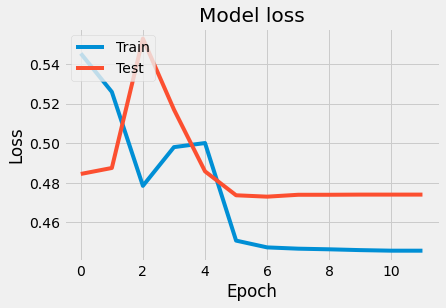

In [11]:
## """可视化下看看训练情况"""
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## 模型架构可视化

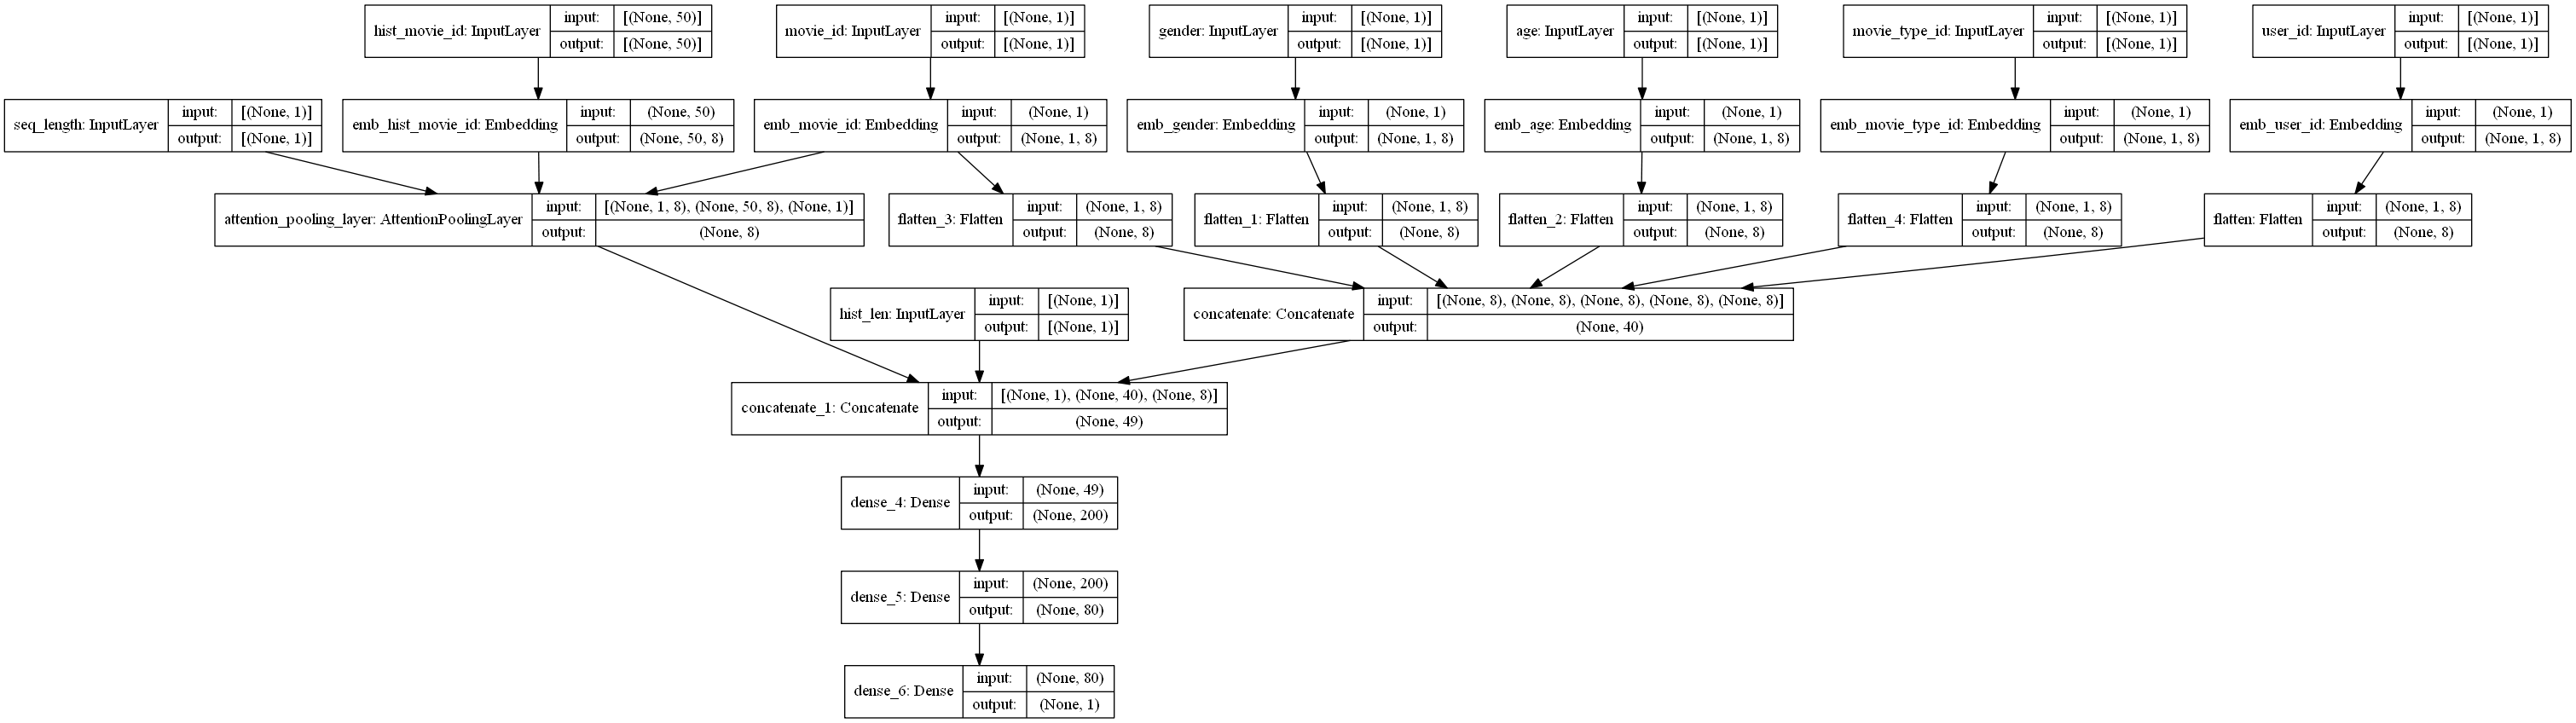

In [12]:
from tensorflow import keras
keras.utils.plot_model(model, to_file='./DIN_arc.png', show_shapes=True)